# The basic notebook

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features

In [336]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [337]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../C/X_test_estimated.parquet')

## Handling the Y-set

In [338]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

In [339]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [340]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.00,1,0,0
2019-06-02 23:00:00,0.00,1,0,0
2019-06-03 00:00:00,0.00,1,0,0
2019-06-03 01:00:00,0.00,1,0,0
2019-06-03 02:00:00,19.36,1,0,0


Setting the index to **date_forecast** and resampling with mean.

In [341]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').mean()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').mean()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').mean()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').mean()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').mean()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').mean()


In [342]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [343]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

In [344]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [345]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0,1,0,5.525,1.23975,1200.675049,0.0,0.0,1200.675049,...,0.0,278.250000,86.324997,16827.800781,2.800,1.175,2.550,0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.475,1.24075,1130.025024,0.0,0.0,1130.025024,...,0.0,278.350006,83.824997,16509.250000,2.900,1.125,2.625,0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.350,1.24000,1066.674927,0.0,0.0,1066.674927,...,0.0,278.200012,99.074997,13277.525391,3.650,1.425,3.350,0.0,0,NaT
2019-01-01 01:00:00,0.0,0,1,0,5.425,1.23975,1131.424927,0.0,0.0,1131.424927,...,0.0,278.075012,99.074997,12777.449219,3.550,1.525,3.200,0.0,0,NaT
2019-01-01 02:00:00,0.0,0,1,0,5.400,1.23850,1061.000000,0.0,0.0,1061.000000,...,0.1,278.049988,97.925003,11140.500000,4.025,2.150,3.425,0.0,0,NaT


In [346]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,dayofyear,dayofmonth,weekofyear,is_weekend,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0,1,0,5.525,1.23975,1200.675049,0.0,0.0,1200.675049,...,1,1,1,0,3,0,0.935294,0.353871,-0.0,0.0
2019-01-01 00:00:00,NaN,0,0,1,5.475,1.24075,1130.025024,0.0,0.0,1130.025024,...,1,1,1,0,3,0,0.935234,0.354030,-0.0,0.0
2019-01-01 01:00:00,NaN,0,0,1,5.350,1.24000,1066.674927,0.0,0.0,1066.674927,...,1,1,1,0,3,0,0.762355,0.647159,-0.0,0.0
2019-01-01 01:00:00,0.0,0,1,0,5.425,1.23975,1131.424927,0.0,0.0,1131.424927,...,1,1,1,0,3,0,0.762586,0.646886,-0.0,0.0
2019-01-01 02:00:00,0.0,0,1,0,5.400,1.23850,1061.000000,0.0,0.0,1061.000000,...,1,1,1,0,3,0,0.532802,0.846240,-0.0,0.0


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [347]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [348]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [349]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3      72
air_density_2m:kgm3           72
clear_sky_energy_1h:J         72
clear_sky_rad:W               72
dew_or_rime:idx               72
                            ... 
location_A                     0
location_B                     0
location_C                     0
estimated                      0
pv_measurement              6063
Length: 62, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 62, dtype: int64
DROPNA RESULTED IN 6135 ROWS BEING DROPPED. THE DATASET HAS 92951 ROWS IN TOTAL.


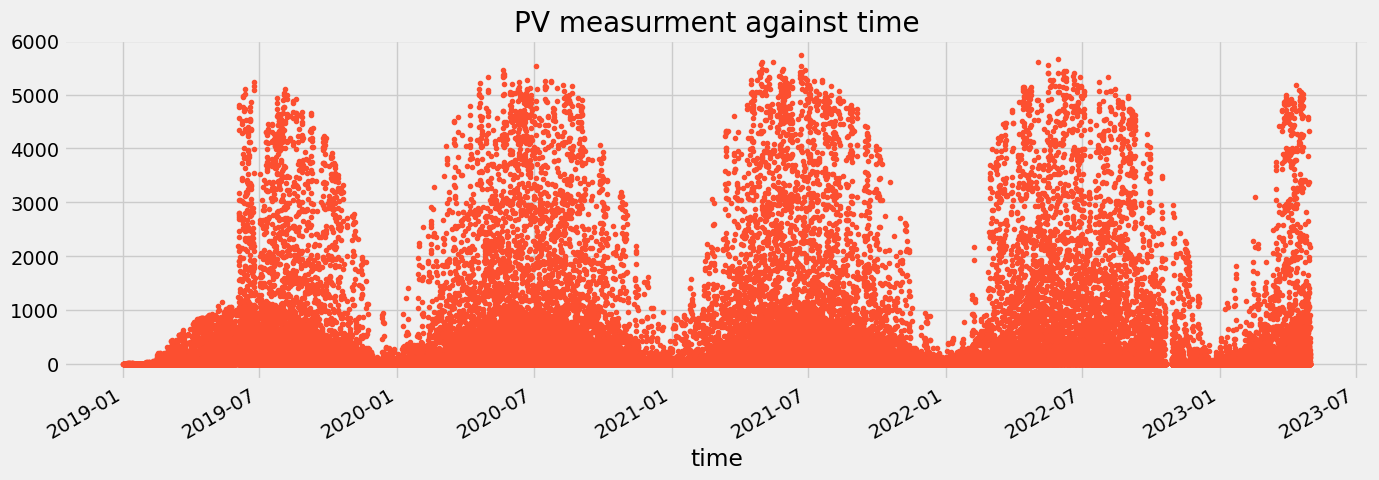

In [350]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [351]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)

    x_test = x_test.resample('60min').mean()

    x_test = create_features(x_test)
    x_test['estimated'] = 1

    if location == 'A':
        x_test['location_A'], X_train_estimated_a['location_A'] = 1, 1
        x_test['location_B'], X_train_estimated_a['location_B'] = 0, 0
        x_test['location_C'], X_train_estimated_a['location_C'] = 0, 0
    elif location == 'B':
        x_test['location_A'], X_train_estimated_a['location_A'] = 0, 0
        x_test['location_B'], X_train_estimated_a['location_B'] = 1, 1
        x_test['location_C'], X_train_estimated_a['location_C'] = 0, 0
    elif location == 'C':
        x_test['location_A'], X_train_estimated_a['location_A'] = 0, 0
        x_test['location_B'], X_train_estimated_a['location_B'] = 0, 0
        x_test['location_C'], X_train_estimated_a['location_C'] = 1, 1

    return x_test

In [352]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [353]:
test_sub = pd.read_csv('../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [354]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_a.loc[valid_dates]
x_test_c = x_test_a.loc[valid_dates]

In [355]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

### Disability Check

Check if the training data and the test data contains the same columns.

In [356]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [357]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


### The model

This uses XGBOOST with GRIDSEARCH.

For further hyperparameter tuning, you can add more values in the parameters variable. The current version is "weak".

In [358]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


cv_split = TimeSeriesSplit(n_splits=5)
model = XGBRegressor()

parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}

X_train = df[FEATURES]
y_train = df[TARGET]

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_xgb_model = grid_search.best_estimator_

# Get feature importances from this best model
feature_importances = best_xgb_model.feature_importances_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.5s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.6s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.8s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.8s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.8s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=700; total time=   0.8s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=700; total time=   1.4s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=700; total time=   2.0s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=700; total time=   2.2s
[CV] END colsample_bytree=0.3, learning

### Get Feature imporances

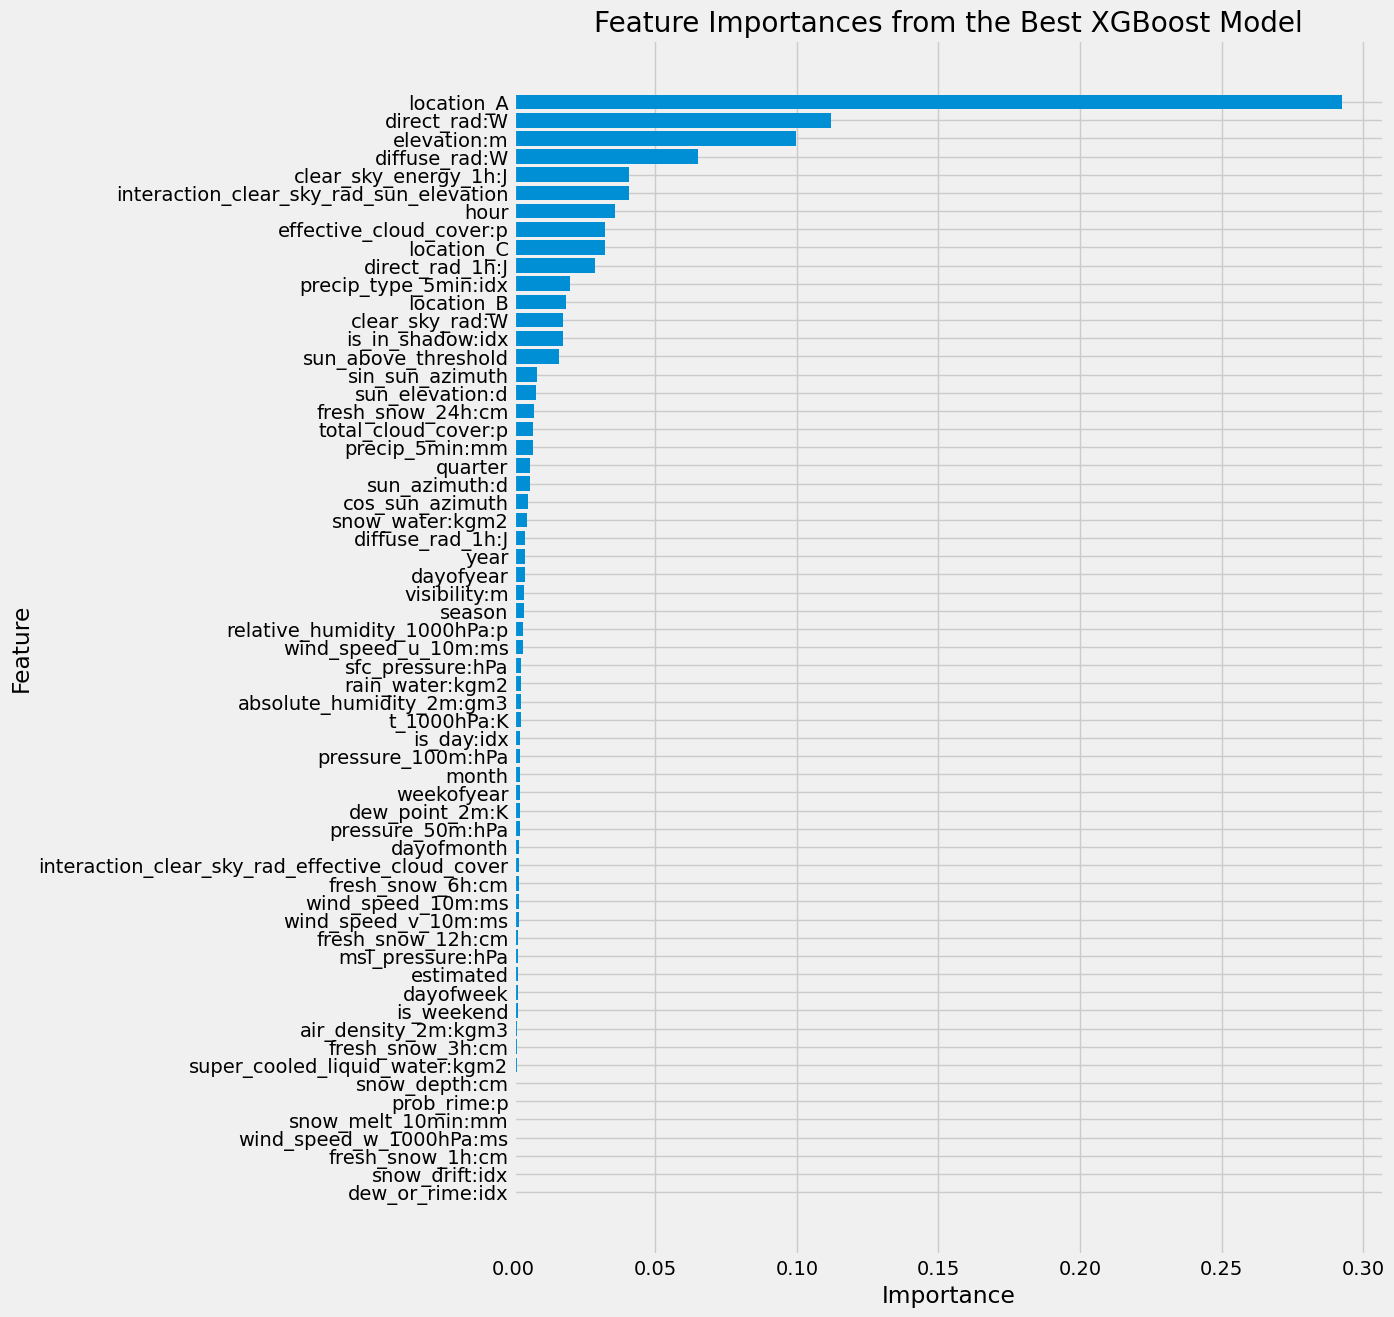

In [359]:
import matplotlib.pyplot as plt

# Sort importances
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot
plt.figure(figsize=(10, 15))
plt.barh(X_train.columns[sorted_idx], feature_importances[sorted_idx])
plt.gca().invert_yaxis()  # Show the most important feature at the top
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from the Best XGBoost Model')
plt.show()

### Predict and make csv

In [360]:
predictions = grid_search.predict(X_test)

In [361]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [362]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)